# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [1]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import keras
from keras.backend import clear_session
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications import DenseNet201

# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [2]:
#############
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#############

**2) Check the shape of images and targets.**

In [3]:
#############
print('X_train shape:', x_train.shape)
print('Y_train shape:', y_train.shape)
print('X_test shape:', x_test.shape)
print('Y_test shape:', y_test.shape)
#############

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 1)


**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [4]:
#############
list_cat = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
y_train_str = np.array([list_cat[i] for i in y_train.reshape(1, -1)[0]]).reshape(-1, 1)
y_test_str = np.array([list_cat[i] for i in y_test.reshape(1, -1)[0]]).reshape(-1, 1)
#############

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [5]:
#############
x_train = x_train/255
x_test  = x_test/255
#############

**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [6]:
#############
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
#############

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

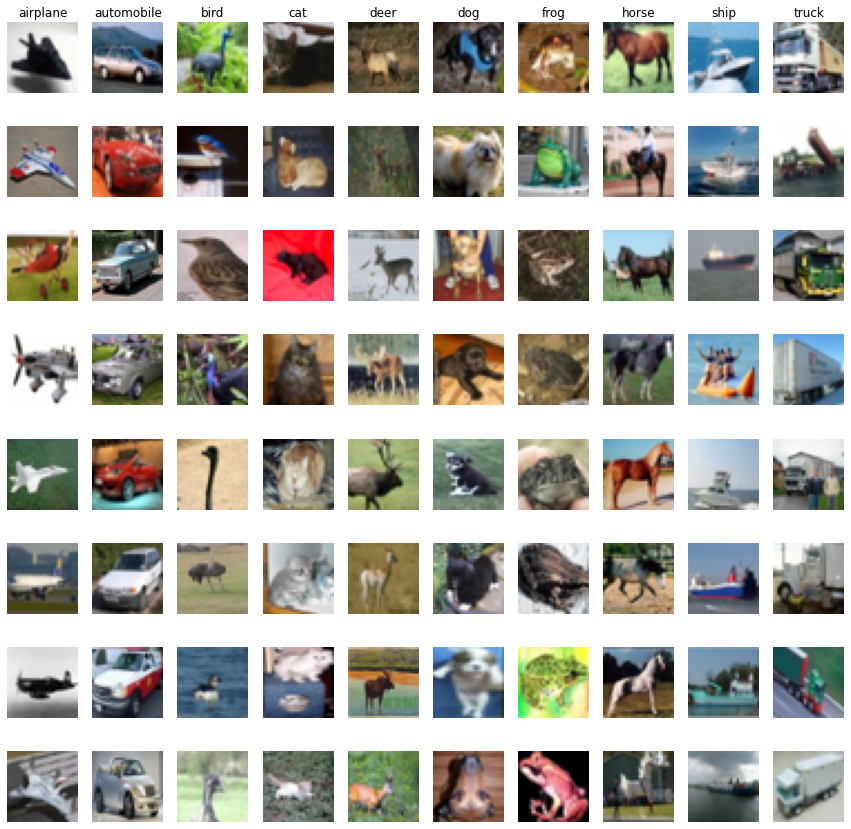

In [7]:
#############
fig = plt.figure(figsize=(15,15))

i = 0
list_im_num = np.zeros(10)
for i in range(y_train.shape[0]):
    cat_num = y_train[i, 0]
    im_num_value = list_im_num[cat_num]
    if sum(list_im_num) == 80: break
    if im_num_value != 8:
        fig.add_subplot(8, 10, 1 + cat_num + 10 * im_num_value)
        plt.imshow(x_train[i])
        plt.axis('off')
        if im_num_value == 0: plt.title(list_cat[cat_num])
        list_im_num[cat_num] += 1

plt.show()   
#############

The following code summarizes the previous operations. 

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 1)


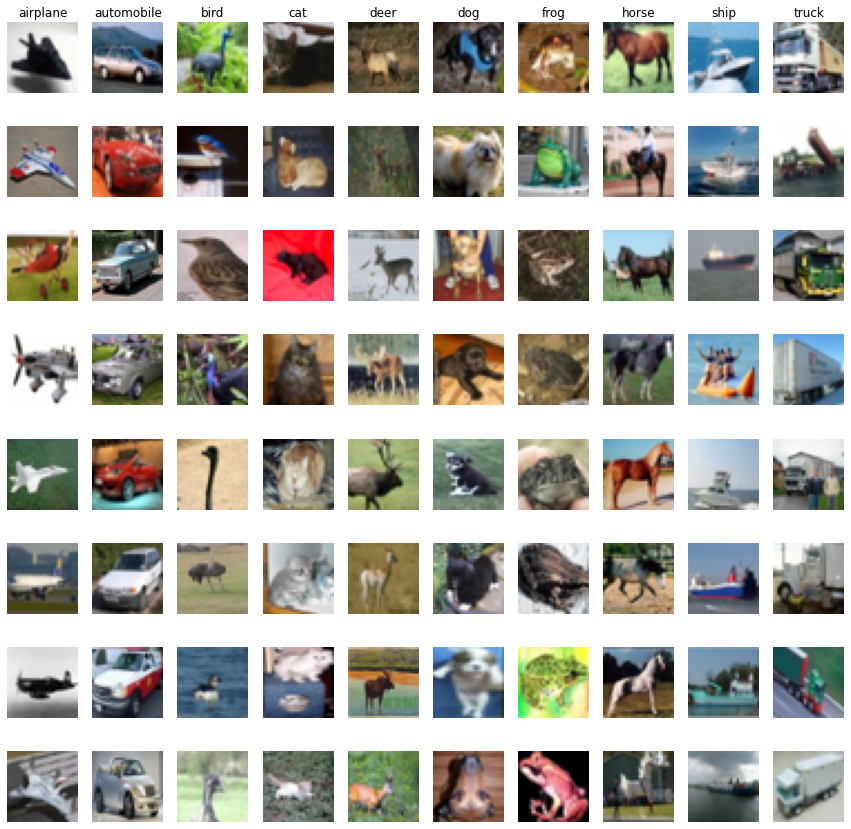

In [8]:
#############
def prepimg():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    print('X_train shape:', x_train.shape)
    print('Y_train shape:', y_train.shape)
    print('X_test shape:', x_test.shape)
    print('Y_test shape:', y_test.shape)
    
    list_cat = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    y_train_str = np.array([list_cat[i] for i in y_train.reshape(1, -1)[0]]).reshape(-1, 1)
    y_test_str = np.array([list_cat[i] for i in y_test.reshape(1, -1)[0]]).reshape(-1, 1)
    
    x_train = x_train/255
    x_test  = x_test/255
    
    fig = plt.figure(figsize=(15,15))

    i = 0
    list_im_num = np.zeros(10)
    for i in range(y_train.shape[0]):
        cat_num = y_train[i, 0]
        im_num_value = list_im_num[cat_num]
        if sum(list_im_num) == 80: break
        if im_num_value != 8:
            fig.add_subplot(8, 10, 1 + cat_num + 10 * im_num_value)
            plt.imshow(x_train[i])
            plt.axis('off')
            if im_num_value == 0: plt.title(list_cat[cat_num])
            list_im_num[cat_num] += 1

    plt.show()  
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = prepimg()
#############

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [9]:
######################
inshape = x_train.shape[1:]
n_classes = y_train.shape[1]

model = Sequential()
model.add(Flatten(input_shape=inshape, name='flat_inp'))
model.add(Dense(2048, activation='relu', name='hidden1'))
model.add(Dense(1024, activation='relu', name='hidden2'))
model.add(Dense(512, activation='relu', name='hidden3'))
model.add(Dense(256, activation='relu', name='hidden4'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
######################

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

hidden1 = (32 * 32 * 3 * 1) * 2048 + 2048 = 6,293,504\
hidden2 = 2048 * 1024 + 1024 = 2,098,176\
hidden3 = 1024 * 512 + 512 = 524,800\
hidden4 = 512 * 256 + 256 = 131,328\
softmax = 256 * 10 + 10 = 2570\
Total parameters = hidden1 + hidden2 + hidden3 + hidden4 + softmax = 9,050,378\
Thus, there are a total of 9,050,378 parameters.

**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [10]:
######################
print(model.summary())
######################

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flat_inp (Flatten)           (None, 3072)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
hidden2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
hidden3 (Dense)              (None, 512)               524800    
_________________________________________________________________
hidden4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
______________________________________________

**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [11]:
######################
batch_size = 32
epochs = 10

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='loss', patience=1)],
                    validation_data=(x_test, y_test),
                    verbose=1
                   )
######################

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.9622 - accuracy: 0.2898 - val_loss: 1.6499 - val_accuracy: 0.4125
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6613 - accuracy: 0.4089 - val_loss: 1.5757 - val_accuracy: 0.4389
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5595 - accuracy: 0.4465 - val_loss: 1.5379 - val_accuracy: 0.4458
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4814 - accuracy: 0.4736 - val_loss: 1.5651 - val_accuracy: 0.4520
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4319 - accuracy: 0.4897 - val_loss: 1.5055 - val_accuracy: 0.4638
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3900 - accuracy: 0.5032 - val_loss: 1.4415 - val_accuracy: 0.4862
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3389 - accuracy: 0.5226 - val_loss: 1.4088 - val_accuracy:

**11) Plot several images with their predictions. Any comment?**

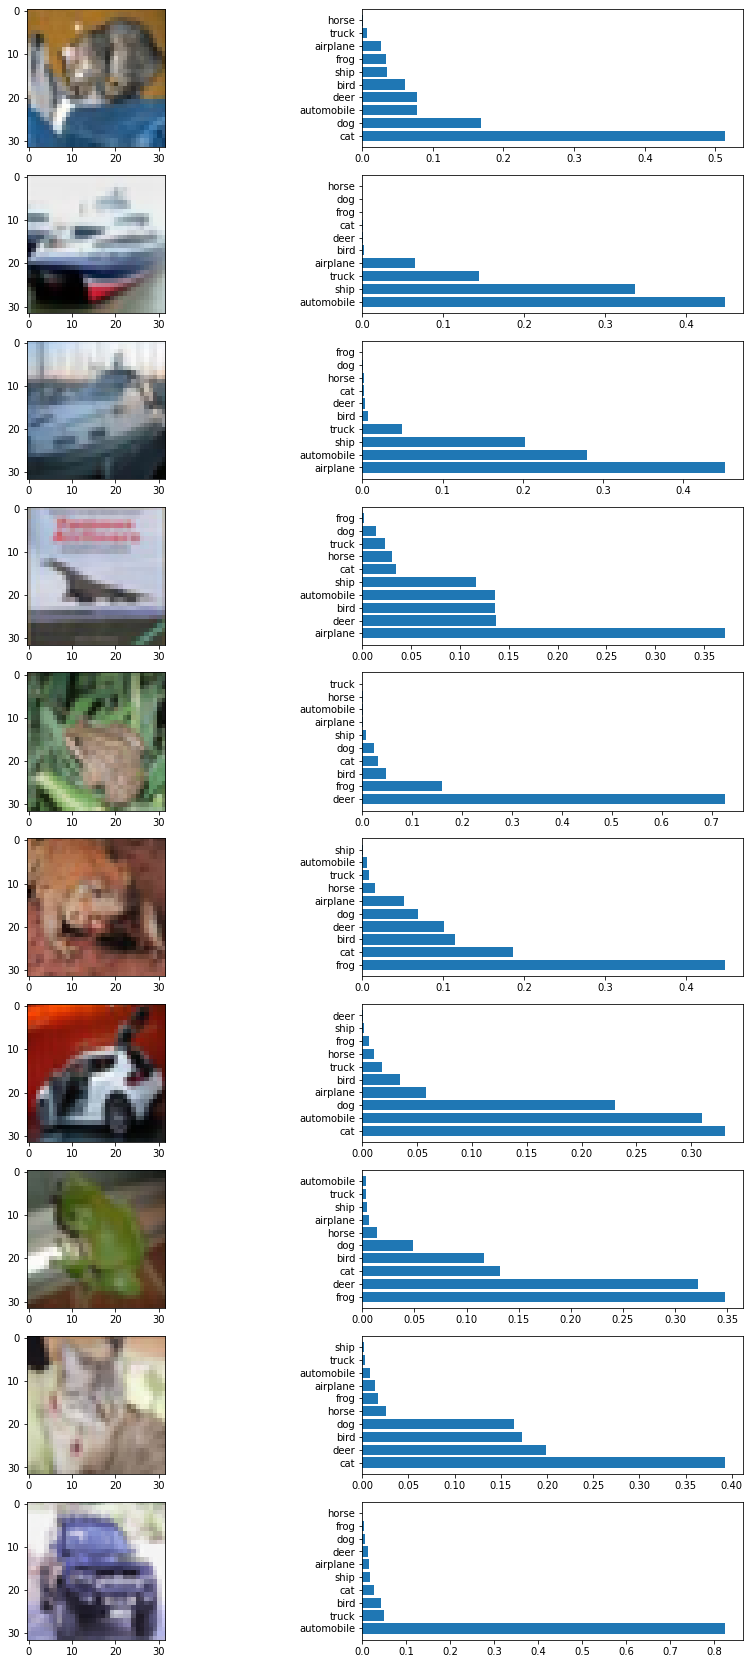

In [12]:
##################
n = 10
fig = plt.figure(figsize=(15, 30))
m_new = model.predict(x_test[:n])

for i in range(n):
    fig.add_subplot(10, 2, 2*i + 1)
    plt.imshow(x_test[i])
    ind = m_new[i].argsort()[::-1]
    fig.add_subplot(10, 2, 2*i + 2)
    plt.barh([list_cat[i] for i in ind], m_new[i, ind])
##################

We observe that the accuracy is rather low (around 50%).

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [13]:
######################
model_cnn = Sequential()
# Bx32x32x3
model_cnn.add(Conv2D(32, (3,3), activation='relu', padding='same', name='conv1', input_shape=inshape))
# Bx32x32x32
model_cnn.add(Conv2D(32, (3,3), activation='relu', padding='valid', name='conv2'))
# Bx30x30x32
model_cnn.add(MaxPooling2D(pool_size=(2,2), name='maxpool1'))
# Bx15x15x32
model_cnn.add(Conv2D(64, (3,3), activation='relu', padding='valid', name='conv3'))
# Bx13x13x64
model_cnn.add(Conv2D(64, (3,3), activation='relu', padding='valid', name='conv4'))
# Bx11x11x64
model_cnn.add(MaxPooling2D(pool_size=(2,2), name='maxpool2'))
# Bx5x5x64
model_cnn.add(Flatten(name='flat'))
model_cnn.add(Dense(512, activation='relu', name='fc1'))
model_cnn.add(Dense(n_classes, activation='softmax'))

model_cnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model_cnn.save_weights("weights.h5")
######################

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

conv1 = (3 * 3 * 3 + 1) * 32 = 896\
conv2 = (3 * 3 * 32 + 1) * 9248\
conv3 = (3 * 3 * 32 + 1) * 64 = 18,496\
conv4 = (3 * 3 * 64 + 1) * 64 = 36,928\
fc1 = 5 * 5 * 64 * 512 + 512 = 819,712\
softmax = 512 * 10 + 10 = 5130\
Total parameters = conv1 + conv2 + conv3 + conv4 + fc1 + softmax = 890,410\
Thus, there are a total of 890,410 parameters. This is less than the naive model as we use filters instead of dense connections, which reduces the first two dimensions while increasing the depth.

In [14]:
######################
model_cnn.summary()
######################

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 15, 15, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 11, 11, 64)        36928     
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 5, 5, 64)          0         
_________________________________________________________________
flat (Flatten)               (None, 1600)             

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [15]:
######################
history = model_cnn.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='loss', patience=1)],
                    validation_data=(x_test, y_test),
                    verbose=1,
                   )
######################

Epoch 1/10
1563/1563 [==============================] - 9s 4ms/step - loss: 2.1408 - accuracy: 0.1972 - val_loss: 1.8507 - val_accuracy: 0.3305
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6636 - accuracy: 0.4039 - val_loss: 1.4946 - val_accuracy: 0.4560
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4374 - accuracy: 0.4853 - val_loss: 1.4074 - val_accuracy: 0.4871
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3042 - accuracy: 0.5387 - val_loss: 1.2310 - val_accuracy: 0.5646
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2004 - accuracy: 0.5730 - val_loss: 1.2248 - val_accuracy: 0.5715
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1132 - accuracy: 0.6082 - val_loss: 1.2267 - val_accuracy: 0.5673
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0263 - accuracy: 0.6398 - val_loss: 1.1347 - val_accuracy:

The validation accuracy increases with the number of epochs, but seems to taper off after 5-6 epochs.

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

In [16]:
######################
batch_size_bigger = 64
model_cnn.load_weights("weights.h5")

history_bigger_b = model_cnn.fit(x_train, y_train,
                    batch_size=batch_size_bigger,
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='loss', patience=1)],
                    validation_data=(x_test, y_test),
                    verbose=1,
                   )
######################

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 2.1127 - accuracy: 0.2171 - val_loss: 1.9230 - val_accuracy: 0.3165
Epoch 2/10
782/782 [==============================] - 4s 6ms/step - loss: 1.8329 - accuracy: 0.3437 - val_loss: 1.7553 - val_accuracy: 0.3632
Epoch 3/10
782/782 [==============================] - 4s 6ms/step - loss: 1.6216 - accuracy: 0.4225 - val_loss: 1.5677 - val_accuracy: 0.4334
Epoch 4/10
782/782 [==============================] - 4s 6ms/step - loss: 1.4805 - accuracy: 0.4715 - val_loss: 1.5896 - val_accuracy: 0.4350
Epoch 5/10
782/782 [==============================] - 4s 6ms/step - loss: 1.3865 - accuracy: 0.5060 - val_loss: 1.4578 - val_accuracy: 0.4775
Epoch 6/10
782/782 [==============================] - 4s 6ms/step - loss: 1.3162 - accuracy: 0.5332 - val_loss: 1.5861 - val_accuracy: 0.4409
Epoch 7/10
782/782 [==============================] - 4s 6ms/step - loss: 1.2485 - accuracy: 0.5585 - val_loss: 1.2982 - val_accuracy: 0.5338
Epoch 

In [17]:
######################
batch_size_smaller = 16
model_cnn.load_weights("weights.h5")

history_smaller_b = model_cnn.fit(x_train, y_train,
                    batch_size=batch_size_smaller,
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='loss', patience=1)],
                    validation_data=(x_test, y_test),
                    verbose=1,
                   )
######################

Epoch 1/10
3125/3125 [==============================] - 11s 4ms/step - loss: 1.8579 - accuracy: 0.3255 - val_loss: 1.5541 - val_accuracy: 0.4441
Epoch 2/10
3125/3125 [==============================] - 11s 4ms/step - loss: 1.4340 - accuracy: 0.4874 - val_loss: 1.3174 - val_accuracy: 0.5305
Epoch 3/10
3125/3125 [==============================] - 11s 4ms/step - loss: 1.2535 - accuracy: 0.5541 - val_loss: 1.2093 - val_accuracy: 0.5692
Epoch 4/10
3125/3125 [==============================] - 11s 4ms/step - loss: 1.1190 - accuracy: 0.6019 - val_loss: 1.1873 - val_accuracy: 0.5918
Epoch 5/10
3125/3125 [==============================] - 11s 4ms/step - loss: 0.9980 - accuracy: 0.6511 - val_loss: 1.0699 - val_accuracy: 0.6266
Epoch 6/10
3125/3125 [==============================] - 11s 4ms/step - loss: 0.8915 - accuracy: 0.6892 - val_loss: 0.9988 - val_accuracy: 0.6489
Epoch 7/10
3125/3125 [==============================] - 11s 4ms/step - loss: 0.7892 - accuracy: 0.7260 - val_loss: 0.9599 - val_ac

Bigger batch size reults in lower accuracy but trains faster. Conversely, smaller batches take longer to train but provide better accuracy.

**16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomenon?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model? How does the performance vary with the dropout ratio?**

In [18]:
######################
model_cnn_dr = Sequential()
# Bx32x32x3
model_cnn_dr.add(Conv2D(32, (3,3), activation='relu', padding='same', name='conv1', input_shape=inshape))
# Bx32x32x32
model_cnn_dr.add(Conv2D(32, (3,3), activation='relu', padding='valid', name='conv2'))
# Bx30x30x32
model_cnn_dr.add(Dropout(.25))
# Bx
model_cnn_dr.add(MaxPooling2D(pool_size=(2,2), name='maxpool1'))
# Bx15x15x32
model_cnn_dr.add(Conv2D(64, (3,3), activation='relu', padding='valid', name='conv3'))
# Bx13x13x64
model_cnn_dr.add(Conv2D(64, (3,3), activation='relu', padding='valid', name='conv4'))
# Bx11x11x64
model_cnn_dr.add(Dropout(.25))
model_cnn_dr.add(MaxPooling2D(pool_size=(2,2), name='maxpool2'))
# Bx5x5x64
model_cnn_dr.add(Flatten(name='flat'))
model_cnn_dr.add(Dense(512, activation='relu', name='fc1'))
model_cnn_dr.add(Dropout(.25))
model_cnn_dr.add(Dense(n_classes, activation='softmax'))

model_cnn_dr.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
######################

In [19]:
######################
history_dr = model_cnn_dr.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='loss', patience=1)],
                    validation_data=(x_test, y_test),
                    verbose=1,
                   )
######################

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 2.1015 - accuracy: 0.2188 - val_loss: 1.7460 - val_accuracy: 0.3983
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6346 - accuracy: 0.4063 - val_loss: 1.5545 - val_accuracy: 0.4685
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4668 - accuracy: 0.4700 - val_loss: 1.4470 - val_accuracy: 0.5047
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3543 - accuracy: 0.5138 - val_loss: 1.3528 - val_accuracy: 0.5511
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2437 - accuracy: 0.5542 - val_loss: 1.2848 - val_accuracy: 0.5727
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1745 - accuracy: 0.5868 - val_loss: 1.2282 - val_accuracy: 0.5910
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1084 - accuracy: 0.6065 - val_loss: 1.1386 - val_accuracy:

In [20]:
######################
# Higher dropout ratio = 0.5
model_cnn_dr_higher = Sequential()
# Bx32x32x3
model_cnn_dr_higher.add(Conv2D(32, (3,3), activation='relu', padding='same', name='conv1', input_shape=inshape))
# Bx32x32x32
model_cnn_dr_higher.add(Conv2D(32, (3,3), activation='relu', padding='valid', name='conv2'))
# Bx30x30x32
model_cnn_dr_higher.add(Dropout(.5))
# Bx
model_cnn_dr_higher.add(MaxPooling2D(pool_size=(2,2), name='maxpool1'))
# Bx15x15x32
model_cnn_dr_higher.add(Conv2D(64, (3,3), activation='relu', padding='valid', name='conv3'))
# Bx13x13x64
model_cnn_dr_higher.add(Conv2D(64, (3,3), activation='relu', padding='valid', name='conv4'))
# Bx11x11x64
model_cnn_dr_higher.add(Dropout(.5))
model_cnn_dr_higher.add(MaxPooling2D(pool_size=(2,2), name='maxpool2'))
# Bx5x5x64
model_cnn_dr_higher.add(Flatten(name='flat'))
model_cnn_dr_higher.add(Dense(512, activation='relu', name='fc1'))
model_cnn_dr_higher.add(Dropout(.5))
model_cnn_dr_higher.add(Dense(n_classes, activation='softmax'))

model_cnn_dr_higher.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
######################

In [21]:
######################
history_dr_higher = model_cnn_dr_higher.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='loss', patience=1)],
                    validation_data=(x_test, y_test),
                    verbose=1,
                   )
######################

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 2.0912 - accuracy: 0.2195 - val_loss: 1.8963 - val_accuracy: 0.4058
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6822 - accuracy: 0.3868 - val_loss: 1.8804 - val_accuracy: 0.3810
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5010 - accuracy: 0.4534 - val_loss: 1.6682 - val_accuracy: 0.4878
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3984 - accuracy: 0.4956 - val_loss: 1.6315 - val_accuracy: 0.4773
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3156 - accuracy: 0.5291 - val_loss: 1.5710 - val_accuracy: 0.4933
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2595 - accuracy: 0.5530 - val_loss: 1.4327 - val_accuracy: 0.5668
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2031 - accuracy: 0.5685 - val_loss: 1.5400 - val_accuracy:

This phenomenon is overfitting of the model. Dropout regularization is one of the way to reduce it. With dropout layers of ratio 0.25 the model performance improves significantly, both in loss and accuracy. Besides, the accuracy and validation accuracy are more steadily rising together.
Dropout layers with ratio 0.5 provides worse results for the model comparing with dropout with ratio 0.25. If compared to the original model, it decreases loss but shows lower accuracy, likely due to slower rate of training.

**17) Add batch normalization layers before each dropout layer. What is their impact on the model's performance?**

In [22]:
######################
model_cnn_dr_bnorm = Sequential()
# Bx32x32x3
model_cnn_dr_bnorm.add(Conv2D(32, (3,3), activation='relu', padding='same', name='conv1', input_shape=inshape))
# Bx32x32x32
model_cnn_dr_bnorm.add(Conv2D(32, (3,3), activation='relu', padding='valid', name='conv2'))
# Bx30x30x32
model_cnn_dr_bnorm.add(BatchNormalization())
model_cnn_dr_bnorm.add(Dropout(.25))
model_cnn_dr_bnorm.add(MaxPooling2D(pool_size=(2,2), name='maxpool1'))
# Bx15x15x32
model_cnn_dr_bnorm.add(Conv2D(64, (3,3), activation='relu', padding='valid', name='conv3'))
# Bx13x13x64
model_cnn_dr_bnorm.add(Conv2D(64, (3,3), activation='relu', padding='valid', name='conv4'))
# Bx11x11x64
model_cnn_dr_bnorm.add(BatchNormalization())
model_cnn_dr_bnorm.add(Dropout(.25))
model_cnn_dr_bnorm.add(MaxPooling2D(pool_size=(2,2), name='maxpool2'))
# Bx5x5x64
model_cnn_dr_bnorm.add(Flatten(name='flat'))
model_cnn_dr_bnorm.add(Dense(512, activation='relu', name='fc1'))
model_cnn_dr_bnorm.add(BatchNormalization())
model_cnn_dr_bnorm.add(Dropout(.25))
model_cnn_dr_bnorm.add(Dense(n_classes, activation='softmax'))

model_cnn_dr_bnorm.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
######################

In [23]:
######################
history_dr_bnorm = model_cnn_dr_bnorm.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='loss', patience=1)],
                    validation_data=(x_test, y_test),
                    verbose=1,
                   )
######################

Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 2.0703 - accuracy: 0.3183 - val_loss: 1.6110 - val_accuracy: 0.4430
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3660 - accuracy: 0.5154 - val_loss: 1.5200 - val_accuracy: 0.4858
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1637 - accuracy: 0.5949 - val_loss: 2.3401 - val_accuracy: 0.3492
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0477 - accuracy: 0.6320 - val_loss: 1.2141 - val_accuracy: 0.5859
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9597 - accuracy: 0.6627 - val_loss: 1.2216 - val_accuracy: 0.6046
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8940 - accuracy: 0.6845 - val_loss: 0.9814 - val_accuracy: 0.6651
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8463 - accuracy: 0.7037 - val_loss: 1.3597 - val_accuracy:

The performance of the model didn't change much in terms of validation loss and accuracy. The training loss and accuracy improved and the training time also increased due to more parameters to compute.

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.

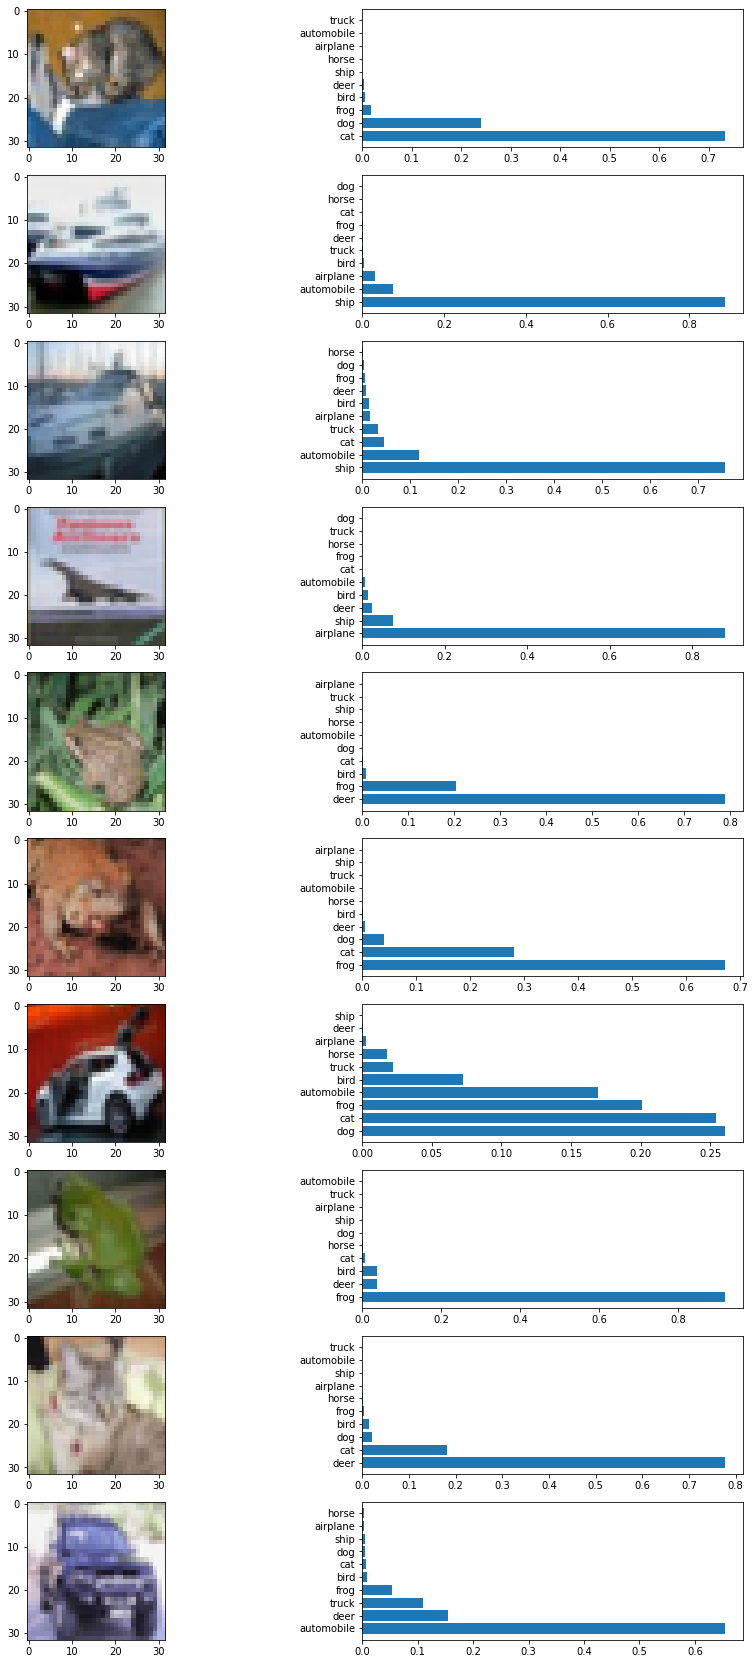

In [24]:
######################
n = 10
fig = plt.figure(figsize=(15, 30))
model_cnn_new = model_cnn_dr_bnorm.predict(x_test[:n])

for i in range(n):
    fig.add_subplot(10, 2, 2*i + 1)
    plt.imshow(x_test[i])
    ind = model_cnn_new[i].argsort()[::-1]
    fig.add_subplot(10, 2, 2 * i + 2)
    plt.barh([list_cat[i] for i in ind], model_cnn_new[i, ind])
######################

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**19) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

In [25]:
######################
y_true = y_test
y_pred = model_cnn_dr_bnorm.predict(x_test)
conf_mat = np.zeros((n_classes, n_classes))
ind_pred = y_pred.argsort(axis=1)[:, n_classes-1]
ind_true = y_true.argmax(axis=1)
list_cat_true = [l+"_true" for l in list_cat]
list_cat_pred = [l+"_pred" for l in list_cat]

for i in range(x_test.shape[0]):
  conf_mat[ind_true[i], ind_pred[i]] += 1

confusion = pd.DataFrame(data=conf_mat.astype(int), columns=list_cat_pred, index=list_cat_true)
confusion.head(10)
######################

,airplane_pred,automobile_pred,bird_pred,cat_pred,deer_pred,dog_pred,frog_pred,horse_pred,ship_pred,truck_pred
airplane_true,514,6,67,57,242,8,19,13,68,6
automobile_true,12,673,17,78,99,10,25,19,27,40
bird_true,41,0,398,142,290,33,74,20,2,0
cat_true,7,0,23,634,200,66,52,17,1,0
deer_true,5,0,16,58,887,6,20,7,1,0
dog_true,2,0,41,314,186,401,21,33,1,1
frog_true,1,0,14,89,117,9,766,4,0,0
horse_true,3,0,18,89,268,30,9,583,0,0
ship_true,31,8,30,72,115,7,24,5,701,7
truck_true,14,32,20,108,116,10,32,46,30,592


According to the confusion matrix, the model's accuracy is around 66%. The confusion matrix shows how many times the predicted and the true values coincide and how many times they do not. It also tells us how often one category is miscategorised as another.

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

**20) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.** 

In [26]:
###########################
input_img = Input(shape=inshape)

model_pretrain = DenseNet201(
    include_top=False,
    weights=None,
    input_shape=inshape    
)

X = model_pretrain(input_img, training=False)

X = Flatten()(X)
X = Dense(n_classes, activation='softmax')(X)
X = Model(inputs=input_img, outputs=X)
X.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X.summary()
##################

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                19210     
Total params: 18,341,194
Trainable params: 18,112,138
Non-trainable params: 229,056
_________________________________________________________________


In [27]:
###########################
history = X.fit(x_train, y_train,
                    batch_size=batch_size_smaller,
                    epochs=epochs,
                    callbacks=[EarlyStopping(monitor='loss', patience=1)],
                    validation_data=(x_test, y_test),
                    verbose=1,
                   )
score = X.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
##################

Epoch 1/10
3125/3125 [==============================] - 207s 61ms/step - loss: 2.0036 - accuracy: 0.2423 - val_loss: 1.4603 - val_accuracy: 0.4590
Epoch 2/10
3125/3125 [==============================] - 192s 62ms/step - loss: 1.3990 - accuracy: 0.4885 - val_loss: 1.2475 - val_accuracy: 0.5491
Epoch 3/10
3125/3125 [==============================] - 195s 62ms/step - loss: 1.2142 - accuracy: 0.5600 - val_loss: 1.1914 - val_accuracy: 0.5730
Epoch 4/10
3125/3125 [==============================] - 197s 63ms/step - loss: 1.1026 - accuracy: 0.6069 - val_loss: 1.1512 - val_accuracy: 0.5850
Epoch 5/10
3125/3125 [==============================] - 206s 66ms/step - loss: 1.0253 - accuracy: 0.6345 - val_loss: 1.0822 - val_accuracy: 0.6179
Epoch 6/10
3125/3125 [==============================] - 201s 64ms/step - loss: 0.9445 - accuracy: 0.6661 - val_loss: 1.1366 - val_accuracy: 0.6068
Epoch 7/10
3125/3125 [==============================] - 191s 61ms/step - loss: 0.8729 - accuracy: 0.6905 - val_loss: 1

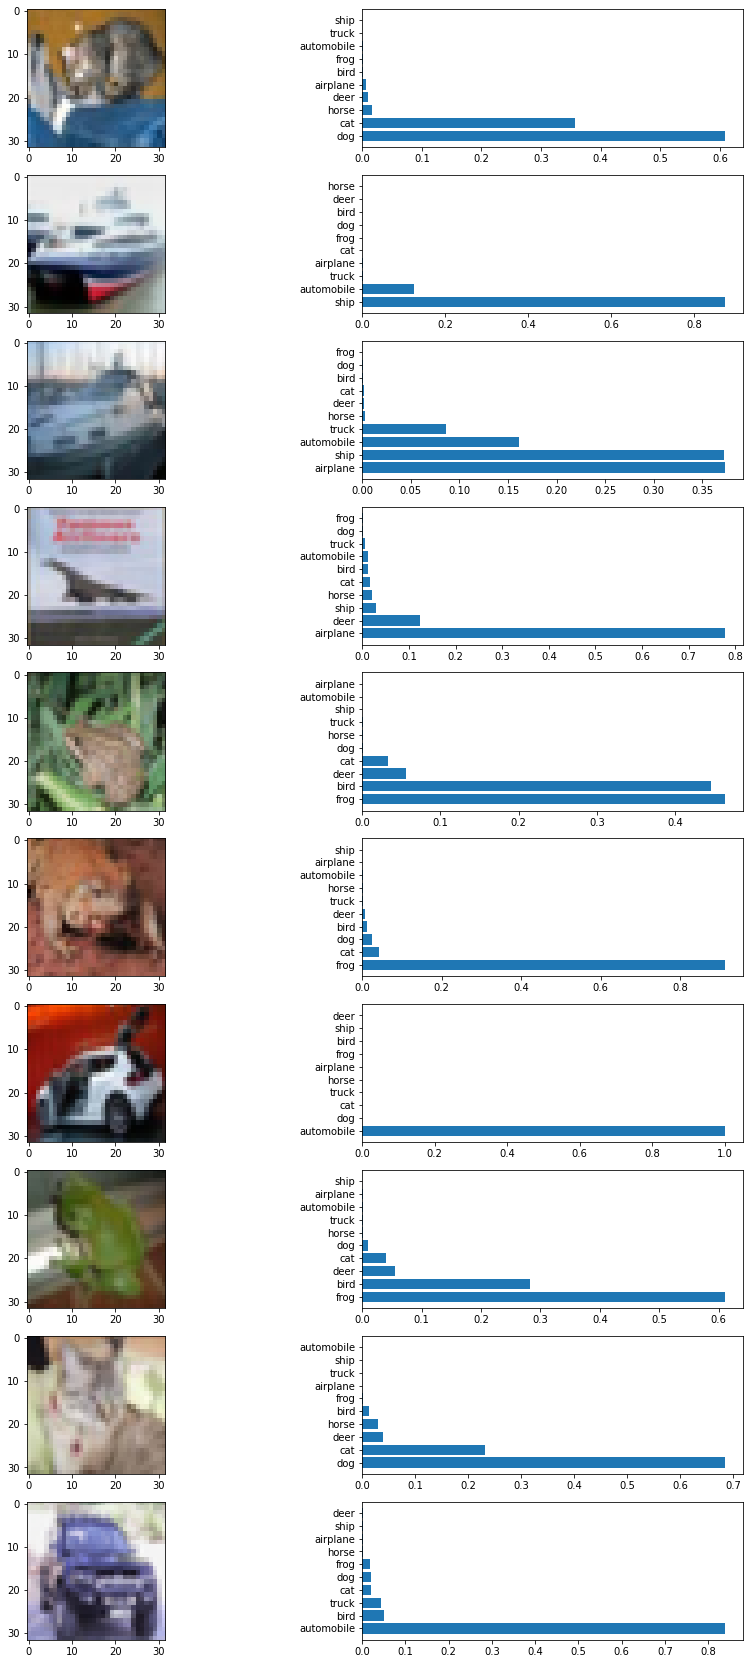

In [28]:
###########################
n = 10
fig = plt.figure(figsize=(15, 30))
m_new = X.predict(x_test[:n])

for i in range(n):
    fig.add_subplot(10, 2, 2*i + 1)
    plt.imshow(x_test[i])
    ind = m_new[i].argsort()[::-1]
    fig.add_subplot(10, 2, 2*i + 2)
    plt.barh([list_cat[i] for i in ind], m_new[i, ind])
##################